In [ ]:
pip install kaggle

In [ ]:
pip install xgboost

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import zipfile

In [4]:
# Set competition name (slug from URL)
competition_name = "playground-series-s5e1"

# Define output directory for the data
output_dir = "."
os.makedirs(output_dir, exist_ok=True)

# Download competition data using Kaggle API
os.system(f"kaggle competitions download -c {competition_name} -p {output_dir}")

print(f"Competition data downloaded to: {output_dir}")

playground-series-s5e1.zip: Skipping, found more recently modified local copy (use --force to force download)
Competition data downloaded to: .


In [5]:
zip_file_path = competition_name + '.zip'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    print("Files in zip:", z.namelist())
    z.extractall()
    #csv_file_name = z.namelist()[0]

Files in zip: ['sample_submission.csv', 'test.csv', 'train.csv']


In [6]:
import matplotlib.pyplot as plt
from datetime import datetime
import time
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Data

In [236]:
data_pack = pd.read_csv("train.csv")
inference_pack = pd.read_csv("test.csv")

Display the shape of the training dataframe and the first five rows

In [8]:
print('(rows,columns) = ',data_pack.shape)
data_pack.head(5)

(rows,columns) =  (230130, 6)


id        date country              store             product  num_sold
0   0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1  2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2   2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3   3  2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4   4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0

## NaNs

In [383]:
# Check if a column has any NaN values
# data_pack['store'].isna().any()

# Show how many NaNs are in num_sold column
NaN_count = data_pack['num_sold'].isna().sum()
print('NaNs in num_sold = ',NaN_count)
print(f'NaNs constitute {round(100*NaN_count/data_pack.shape[0],2)}% of the data')

NaNs in num_sold =  8871
NaNs constitute 3.85% of the data


Let's examine the NaNs by categories or groups of categories

In [12]:
data_pack_nans = data_pack[data_pack['num_sold'].isna()]

group_categories = ['country','store','product']
nans_grouped = data_pack_nans.groupby(group_categories)

for group_name, group_data in nans_grouped:
    print(f'{group_name}: {group_data.shape[0]} NaNs')

('Canada', 'Discount Stickers', 'Holographic Goose'): 2557 NaNs
('Canada', 'Discount Stickers', 'Kerneler'): 1 NaNs
('Canada', 'Premium Sticker Mart', 'Holographic Goose'): 380 NaNs
('Canada', 'Stickers for Less', 'Holographic Goose'): 1308 NaNs
('Kenya', 'Discount Stickers', 'Holographic Goose'): 2557 NaNs
('Kenya', 'Discount Stickers', 'Kerneler'): 63 NaNs
('Kenya', 'Discount Stickers', 'Kerneler Dark Mode'): 1 NaNs
('Kenya', 'Premium Sticker Mart', 'Holographic Goose'): 646 NaNs
('Kenya', 'Stickers for Less', 'Holographic Goose'): 1358 NaNs


## Preprocessing

In [513]:
date_categories = ['dayofweek','dayofyear','dayofmonth','weekofyear','quarter','month']
first_year = float((data_pack.loc[0,'date'])[:4])-1
first_day = data_pack.loc[0,'date']

data_pack[group_categories] = data_pack[group_categories].astype('category')
inference_pack[group_categories] = inference_pack[group_categories].astype('category')

In [228]:
# Split the date-time data into different values (days,months,...)
def datetime_processing(df):

    df_new = df.copy()
    df_date = pd.to_datetime(df['date'])
    df_new.loc[:,'date'] = df_date
    
    df_new['dayofweek'] = df_date.dt.dayofweek
    df_new['quarter'] = df_date.dt.quarter
    df_new['month'] = df_date.dt.month
    df_new['year'] = df_date.dt.year - first_year
    df_new['dayofyear'] = df_date.dt.dayofyear
    df_new['dayofmonth'] = df_date.dt.day
    df_new['weekofyear'] = (df_new['dayofyear'] // 7) + 1

    df_new['oddyear'] = df_date.dt.year % 2
    df_new['daysfromstart'] = df_new['dayofyear'] + 365*(df_new['year'] - 1.0)

    return df_new

In [719]:
data_pack_dt = datetime_processing(data_pack)
data_pack_dt.head(2)

id                 date country              store            product  \
0   0  2010-01-01 00:00:00  Canada  Discount Stickers  Holographic Goose   
1   1  2010-01-01 00:00:00  Canada  Discount Stickers             Kaggle   

   num_sold  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0       NaN          4        1      1   1.0          1           1   
1     973.0          4        1      1   1.0          1           1   

   weekofyear  oddyear  daysfromstart  
0           1        0            1.0  
1           1        0            1.0

In [720]:
data_grouped = data_pack_dt.groupby(group_categories,observed=True)

Although two combinations of categories have no other values than NaNs and some other combinations have a big proportions of NaNs, for the first trial let's assume that we can safely neglect all of them and our algorithm will be efficient enough to predict the sales in these combinations of categories

In [266]:
data_absent_groups = data_pack_dt[(data_pack_dt['product'] == 'Holographic Goose') & (data_pack_dt['store'] == 'Discount Stickers') & ((data_pack_dt['country'] == 'Kenya') | (data_pack_dt['country'] == 'Canada')) ]
data_pack_nonans = data_pack_dt.dropna() 

In [773]:
def residual_processing(df_input):

    df = df_input.copy()

    regression_coefficient = dict()
    regression_index_mean = 1
    regression_index_scale = 1

    years = df['year'].unique()

    #df.loc['norm_res'] = 0

    for group_name, dfg in df.groupby(group_categories,observed=True):

        yearly_mean = []
        yearly_scale = []
        yearly_max = []

        for year in years:

            dfg_year = dfg[dfg['year'] == year].copy()
            
            year_mean = dfg_year['num_sold'].mean()
            residuals = dfg_year['num_sold'] - year_mean
            year_scale = residuals.abs().mean() 
            norm_res = residuals/year_scale
            norm_res_max_value = (residuals/year_scale).max()

            dfg.loc[dfg_year.index,'norm_res'] = norm_res
            df.loc[dfg_year.index,'norm_res'] = norm_res

            yearly_mean.append( year_mean )
            yearly_scale.append( year_scale )
            yearly_max.append(norm_res_max_value)

        
        coefs_mean = np.polyfit(years, yearly_mean, regression_index_mean)
        coefs_scale = np.polyfit(years, yearly_scale, regression_index_scale)

        group_max_mean = np.mean(yearly_max)

        dfg_max = dfg[dfg['norm_res'] > group_max_mean]
        
        df.loc[dfg_max.index,'norm_res'] = group_max_mean

        # coefs_mean = np.polyfit(dfg['daysfromstart'].to_numpy(), dfg['num_sold'].to_numpy(), regression_index_mean)
        # residuals = dfg['num_sold'] - np.polyval(coefs_mean, dfg['daysfromstart'].to_numpy() )
        # coefs_scale = np.polyfit(dfg['daysfromstart'].to_numpy(), residuals.abs(), regression_index_scale)
        # df.loc[dfg.index,'norm_res'] = residuals/np.polyval(coefs_scale, dfg['daysfromstart'].to_numpy() )
        #print(np.polyval(coefs_mean,years))

        regression_coefficient[group_name] = [coefs_mean,coefs_scale]
    
        # #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
        # fig = plt.figure(figsize=(10,4))

        # # Left subplot
        # ax1 = fig.add_subplot(1,2,1)
        # ax1.plot(dfg['daysfromstart'].to_numpy(), dfg['num_sold'].to_numpy(),label='num_sold')  
        # ax1.plot(365*(years-0.5), np.polyval(coefs_mean,years),'--',label='mean')
        # #ax1.plot(dfg['daysfromstart'].to_numpy(), np.polyval(coefs_mean,dfg['daysfromstart'].to_numpy()),'--',label='mean')
        # ax1.legend()
        # ax1.grid()
        # ax1.set_xlabel('Date')
        # ax1.set_ylabel('Num_sold')

        # # Right subplot
        # # ax2 = fig.add_subplot(1,2,2)
        # # ax2.plot(dfg['daysfromstart'].to_numpy(), df.loc[dfg.index,'num_sold'].to_numpy() - np.polyval(coefs_mean,dfg['daysfromstart']/365) )
        # # ax2.plot(365*(years-0.5), np.polyval(coefs_scale,years),'--',label='scale')
        # # ax2.grid()
        # # ax2.set_xlabel('Date')
        # # ax2.set_ylabel('Residuals')

        # ax2 = fig.add_subplot(1,2,2)
        # ax2.plot(dfg['daysfromstart'].to_numpy(), df.loc[dfg.index,'norm_res'].to_numpy() ) 
        # ax2.grid()
        # ax2.set_xlabel('Date')
        # ax2.set_ylabel('Norm_res')

        # plt.tight_layout()
        # plt.title(f'{group_name}')
        # plt.show()

    return df, regression_coefficient


In [495]:
data_pack_new, reg_coefs = residual_processing(data_pack_nonans)

In [271]:
data_pack_new.head(5)

id                 date country              store             product  \
1   1  2010-01-01 00:00:00  Canada  Discount Stickers              Kaggle   
2   2  2010-01-01 00:00:00  Canada  Discount Stickers        Kaggle Tiers   
3   3  2010-01-01 00:00:00  Canada  Discount Stickers            Kerneler   
4   4  2010-01-01 00:00:00  Canada  Discount Stickers  Kerneler Dark Mode   
5   5  2010-01-01 00:00:00  Canada  Stickers for Less   Holographic Goose   

   num_sold  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
1     973.0          4        1      1   1.0          1           1   
2     906.0          4        1      1   1.0          1           1   
3     423.0          4        1      1   1.0          1           1   
4     491.0          4        1      1   1.0          1           1   
5     300.0          4        1      1   1.0          1           1   

   weekofyear  oddyear  daysfromstart  norm_res  
1           1        0            1.0  5.209233  
2           1        0            1.0  7.267286  
3           1        0            1.0  2.574654  
4           1        0            1.0  2.636271  
5           1        0            1.0  4.035099

Plot the normalized residuals as time series for each group of categories

Preparing the training and test datasets

In [272]:
def train_test_split(df,split_date):

    train_data = df[df['date'] < split_date]
    test_data = df[df['date'] >= split_date]

    # Train on normalized residuals
    split_features = 'norm_res'
    
    train_target = train_data[split_features]
    train_data = train_data.drop(columns = split_features)
    test_target = test_data[split_features]
    test_data = test_data.drop(columns = split_features)

    return train_data, train_target, test_data, test_target

In [278]:
split_date = pd.to_datetime('2016-01-01')
train_data, train_target, test_data, test_target = train_test_split(data_pack_new,split_date)

In [274]:
#train_data.head(2)
train_target.head(2)

1    5.209233
2    7.267286
Name: norm_res, dtype: float64

# XGBoost

In [330]:
columns_to_drop = ['id','date','num_sold','daysfromstart','year']
#columns_to_drop = ['id','date','num_sold','quarter','weekofyear','month']

In [392]:
model = xgb.XGBRegressor(n_estimators=1000,
                        #early_stopping_rounds=10,
                        enable_categorical='True',
                        max_depth=8,
                        #max_leaves=15,
                        learning_rate=0.2,random_state=42)
start_time = time.time()
model.fit(train_data.drop(columns=columns_to_drop),train_target,
         #eval_set=[(train_data,train_target),(test_data,test_target)],
          verbose=True)
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

Elapsed time: 6.349291801452637 s


In [395]:
predictions = model.predict(test_data.drop(columns=columns_to_drop))

#prediction_norm_res = predictions[:,0]
#prediction_group_mean = predictions[:,1]
#prediction_group_max_res = predictions[:,2]

df_predictions = test_data[['id','date','country','store','product','year']].copy()
df_predictions['norm_res'] = predictions
df_predictions['num_sold'] = 0.0

def recover_num_sold(df,reg_coefs):

    years = df['year'].unique()
    
    for group_name, group_data in df.groupby(group_categories,observed=True):

        if (group_name == ('Kenya', 'Discount Stickers', 'Holographic Goose') or group_name == ('Kenya', 'Stickers for Less', 'Holographic Goose') or group_name == ('Kenya', 'Premium Sticker Mart', 'Holographic Goose') ):
            for year in years:

                year_mean = np.polyval(reg_coefs[group_name][0],year)

                year_slice = group_data[group_data['year'] == year]

                df.loc[year_slice.index,'num_sold'] = (df.loc[year_slice.index,'norm_res'][df['year'] == year] + year_mean).round()
        
        else:
            
            for year in years:
    
                year_mean = np.polyval(reg_coefs[group_name][0],year)
                year_scale = np.polyval(reg_coefs[group_name][1],year)
    
                year_slice = group_data[group_data['year'] == year]
    
                df.loc[year_slice.index,'num_sold'] = df.loc[year_slice.index,'norm_res'][df['year'] == year]*year_scale + year_mean
        

recover_num_sold(df_predictions,reg_coefs)

df_predictions.head(5)

id                 date country              store  \
197191  197191  2016-01-01 00:00:00  Canada  Discount Stickers   
197192  197192  2016-01-01 00:00:00  Canada  Discount Stickers   
197193  197193  2016-01-01 00:00:00  Canada  Discount Stickers   
197194  197194  2016-01-01 00:00:00  Canada  Discount Stickers   
197195  197195  2016-01-01 00:00:00  Canada  Stickers for Less   

                   product  year  norm_res    num_sold  
197191              Kaggle   7.0  5.332397  961.612915  
197192        Kaggle Tiers   7.0  6.954317  901.468262  
197193            Kerneler   7.0  2.555709  402.479980  
197194  Kerneler Dark Mode   7.0  2.573640  491.397461  
197195   Holographic Goose   7.0  3.931033  280.528564

In [396]:
mean_absolute_percentage_error(test_data['num_sold'],df_predictions['num_sold'])

0.06807538554254748

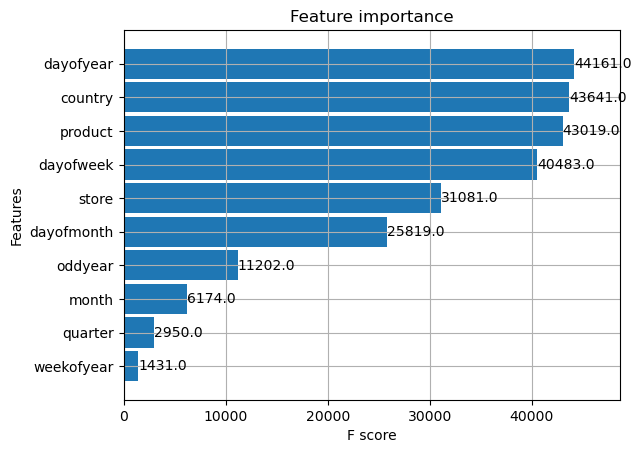

In [397]:
#individual_regressors = model.estimators_
#_ = xgb.plot_importance(individual_regressors[1], height=0.9)

_ = xgb.plot_importance(model, height=0.9)

In [ ]:
# grouped_train = data_pack_new.groupby(group_categories,observed=True)
# grouped_prediction = df_predictions.groupby(group_categories,observed=True)

# for (group_name_train, group_data_train), (group_name_prediction, group_data_prediction) in zip(grouped_train,grouped_prediction):
#     plt.figure(figsize=(5, 2))
#     plt.plot(group_data_train['date'].to_numpy(), group_data_train['num_sold'].to_numpy())
#     plt.plot(group_data_prediction['date'].to_numpy(), group_data_prediction['num_sold'].to_numpy(),marker='o',linestyle='none')
#     plt.xlabel("Date", fontsize=12)
#     plt.ylabel("Sales", fontsize=12)
#     plt.grid(True)
#     plt.legend(title=f"{group_name_train}")
#     plt.show()

# Analyzing and filling NaNs

Holographic Goose stickers have a lot of NaNs - 8806

Holographic Goose stickers in Discount Stickers in Canada and Kenya are all NaNs - 5114 values

Holographic Goose stickers in Stickers for Less in both countries have a lot of missing values too - 1308/2557 and 1358/2557

In [721]:
# "Discount Stickers" have all NaNs
data_kenya_allnans = data_grouped.get_group(('Kenya', 'Discount Stickers', 'Holographic Goose'))
data_canada_allnans = data_grouped.get_group(('Canada', 'Discount Stickers', 'Holographic Goose'))
# "Stickers for Less" have a lot of NaNs
data_kenya_manynans = data_grouped.get_group(('Kenya', 'Stickers for Less', 'Holographic Goose'))
data_canada_manynans = data_grouped.get_group(('Canada', 'Stickers for Less', 'Holographic Goose'))
# "Premium Sticker Mart" have a small number of NaNs
data_kenya_somenans = data_grouped.get_group(('Kenya', 'Premium Sticker Mart', 'Holographic Goose'))
data_canada_somenans = data_grouped.get_group(('Canada', 'Premium Sticker Mart', 'Holographic Goose'))


data_kenya_allnans.head(2)

id                 date country              store            product  \
45    45  2010-01-01 00:00:00   Kenya  Discount Stickers  Holographic Goose   
135  135  2010-01-02 00:00:00   Kenya  Discount Stickers  Holographic Goose   

     num_sold  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
45        NaN          4        1      1   1.0          1           1   
135       NaN          5        1      1   1.0          2           2   

     weekofyear  oddyear  daysfromstart  
45            1        0            1.0  
135           1        0            2.0

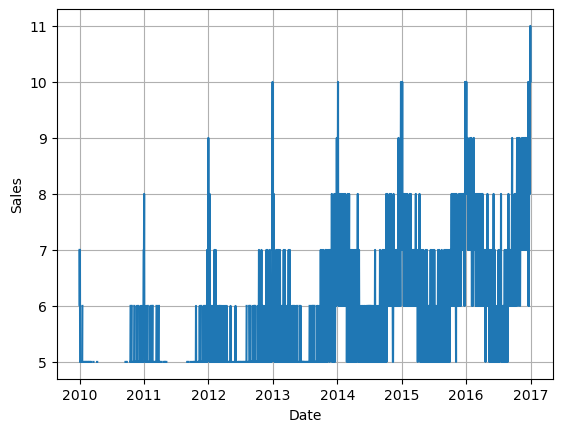

In [625]:
def plot_group(df,df2 = pd.DataFrame()):

    plt.figure()
    plt.plot(df.date.to_numpy(),df.num_sold.to_numpy())
    if not df2.empty:
        plt.plot(df2.date.to_numpy(),df2.num_sold.to_numpy(),marker='o',linestyle='None')
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid()
    plt.show()

plot_group(data_kenya_somenans)

In [777]:
regressors = dict()

def_regressor_args = {
    "n_estimators": 1000,
    #early_stopping_rounds=10,
    "enable_categorical": 'True',
    "max_depth": 8,
    #"max_leaves": 15,
    "learning_rate": 0.05,
    "random_state": 42
}

def predict_for_group_nans(df,df_train,regressor_args = def_regressor_args):

    df_new = df.copy()
    group_regressor = xgb.XGBRegressor(**regressor_args) 
    df_nans = df_new[df_new['num_sold'].isna()]
    df_processed, reg_coefs = residual_processing(df_train.dropna())
    
    group_regressor.fit(df_processed[date_categories],df_processed['norm_res'])

    prediction = group_regressor.predict(df_nans[date_categories])

    df_prediction = df_nans.copy()
    df_prediction.loc[:,'norm_res'] = prediction
    
    recover_num_sold(df_prediction,reg_coefs)

    df_full = df_new.copy()
    df_full.loc[df_nans.index,'num_sold'] = df_prediction['num_sold']

    return df_full

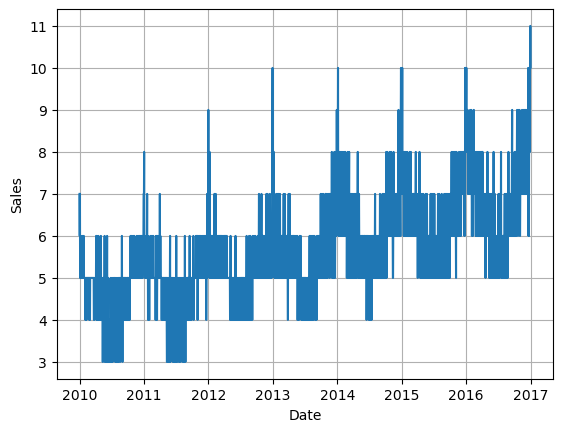

In [778]:
data_kenya_somenans_filled = predict_for_group_nans(data_kenya_somenans,data_kenya_somenans)

plot_group(data_kenya_somenans_filled)

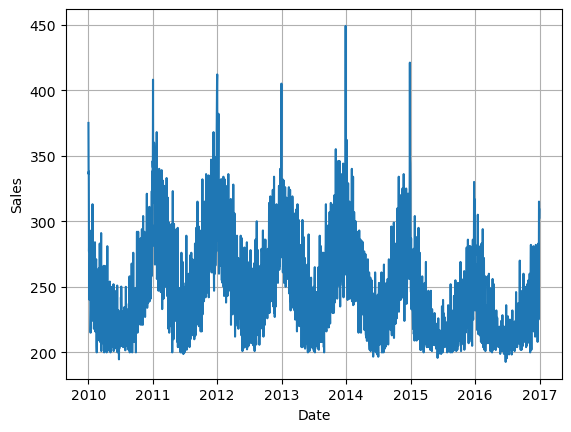

In [693]:
data_canada_somenans_filled = predict_for_group_nans(data_canada_somenans,data_canada_somenans)

plot_group(data_canada_somenans_filled)

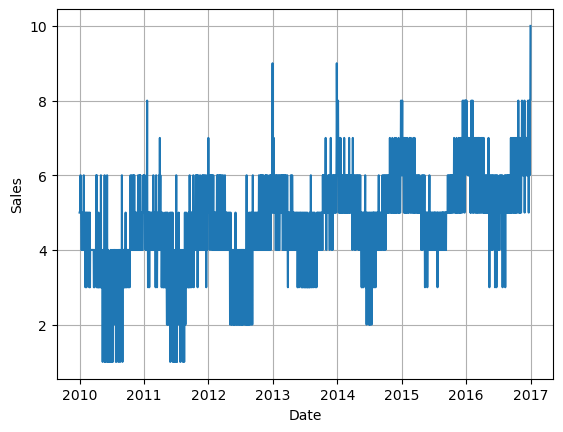

In [785]:
data_kenya_manynans_recovered = data_kenya_manynans.copy()
#data_kenya_manynans_recovered.loc[:,'store'] = 'Stickers for Less'
data_kenya_manynans_recovered.loc[:,'num_sold'] = data_kenya_somenans_filled['num_sold'].to_numpy()/1.185

data_kenya_manynans_filled = predict_for_group_nans(data_kenya_manynans,data_kenya_manynans_recovered)
plot_group(data_kenya_manynans_filled)

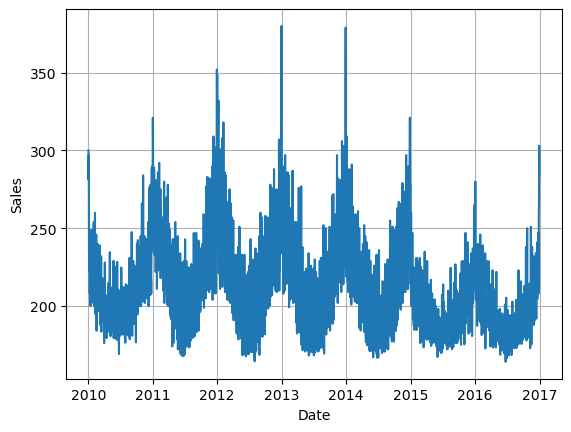

In [790]:
data_canada_manynans_recovered = data_canada_manynans.copy()
#data_canada_manynans_recovered.loc[:,'store'] = 'Stickers for Less'
data_canada_manynans_recovered.loc[:,'num_sold'] = data_canada_somenans_filled['num_sold'].to_numpy()/1.185

data_canada_manynans_filled = predict_for_group_nans(data_canada_manynans,data_canada_manynans_recovered)
plot_group(data_canada_manynans_filled)

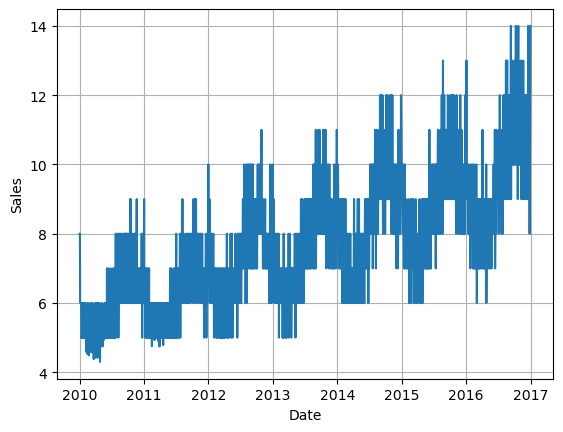

In [722]:
data_kenya_kerneler = data_grouped.get_group(('Kenya', 'Discount Stickers', 'Kerneler'))
data_kenya_kerneler_filled = predict_for_group_nans(data_kenya_kerneler,data_kenya_kerneler)

plot_group(data_kenya_kerneler_filled)

It seems that there might be a certain proportion between sales of stickers in different stores 

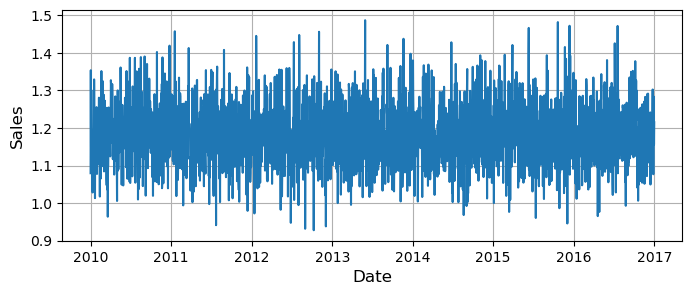

mean ratio:  1.1829440613357247


In [541]:
check_country = 'Norway'

df1 = data_grouped.get_group((check_country, 'Premium Sticker Mart', 'Holographic Goose'))
df2 = data_grouped.get_group((check_country, 'Stickers for Less', 'Holographic Goose'))

plt.figure(figsize=(8, 3))
plt.plot(df1['date'].to_numpy(), df1.num_sold.to_numpy()/df2.num_sold.to_numpy())
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True)
plt.show()

print('mean ratio: ',np.mean(df1.num_sold.to_numpy()/df2.num_sold.to_numpy()))

The same ratio between sales in stores is observed for all the countries for Holographic Stickers (and for other stickers too)

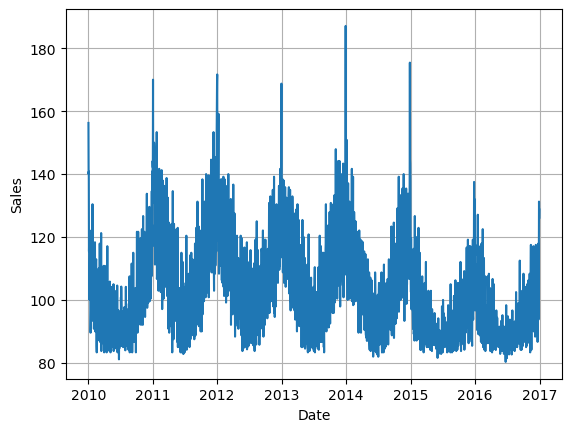

In [787]:
data_canada_allnans_recovered = data_canada_allnans.copy()
#data_canada_allnans_recovered.loc[:,'store'] = 'Discount Stickers'
data_canada_allnans_recovered.loc[:,'num_sold'] = data_canada_somenans_filled['num_sold'].to_numpy()/2.4

data_canada_allnans_filled = predict_for_group_nans(data_canada_allnans,data_canada_allnans_recovered)
plot_group(data_canada_allnans_recovered)

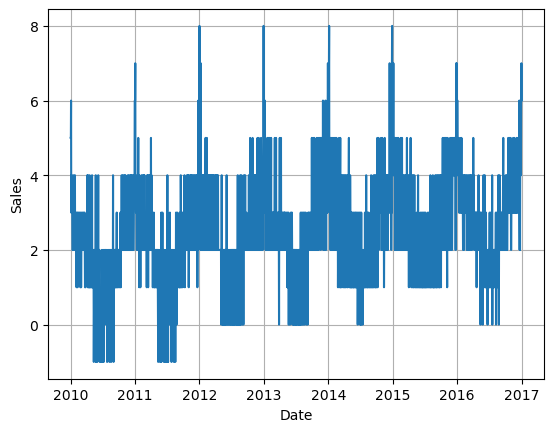

In [789]:
data_kenya_allnans_recovered = data_kenya_allnans.copy()
#data_kenya_allnans_recovered.loc[:,'store'] = 'Discount Stickers'
data_kenya_allnans_recovered.loc[:,'num_sold'] = data_kenya_somenans_filled['num_sold'].to_numpy()/2.4

data_kenya_allnans_filled = predict_for_group_nans(data_kenya_allnans,data_kenya_allnans_recovered)
plot_group(data_kenya_allnans_filled)

We'll take a "recovered" dataset though, as it looks a bit better

In [791]:
data_kenya_allnans_filled.loc[:,'num_sold'] = data_kenya_allnans_recovered['num_sold']

## Filling NaNs

In [795]:
data_pack_dt_filled = data_pack_dt.copy()
print(data_pack_dt_filled['num_sold'].isna().sum())
#print(data_pack_dt_filled.shape)

data_pack_dt_filled.loc[data_canada_manynans_filled.index,'num_sold'] = data_canada_manynans_filled['num_sold']
data_pack_dt_filled.loc[data_canada_somenans_filled.index,'num_sold'] = data_canada_somenans_filled['num_sold']
data_pack_dt_filled.loc[data_kenya_somenans_filled.index,'num_sold'] = data_kenya_somenans_filled['num_sold']
data_pack_dt_filled.loc[data_kenya_manynans_filled.index,'num_sold'] = data_kenya_manynans_filled['num_sold']
data_pack_dt_filled.loc[data_kenya_allnans_filled.index,'num_sold'] = data_kenya_allnans_filled['num_sold']
data_pack_dt_filled.loc[data_canada_allnans_filled.index,'num_sold'] = data_canada_allnans_filled['num_sold']
data_pack_dt_filled.loc[data_kenya_kerneler_filled.index,'num_sold'] = data_kenya_kerneler_filled['num_sold']

print(data_pack_dt_filled['num_sold'].isna().sum())
#print(data_pack_dt_filled.isna().sum())

#data_pack_dt_filled = data_pack_dt_filled.interpolate('linear')
data_pack_dt_filled = data_pack_dt_filled.dropna()

print(data_pack_dt_filled['num_sold'].isna().sum())

8871
2
0


In [ ]:
# for group_name, df in data_pack_dt_filled.groupby(group_categories,observed=True): 
    
#     plt.figure(figsize=(5, 2))
#     plt.plot(df['date'], df['num_sold'], label=f"{group_name}")
#     plt.xlabel("Date", fontsize=12)
#     plt.ylabel("Sales.", fontsize=12)
#     plt.grid(True)
#     plt.legend(title="Feature Combination")
#     plt.show()

## Testing the filled dataset

In [796]:
data_pack_filled, reg_coefs = residual_processing(data_pack_dt_filled)

#split_date = pd.to_datetime('2016-01-01')
train_data_filled, train_target_filled, test_data_filled, test_target_filled = train_test_split(data_pack_filled,split_date)

start_time = time.time()
model.fit(train_data_filled.drop(columns=columns_to_drop),train_target_filled,
         #eval_set=[(train_data,train_target),(test_data,test_target)],
          verbose=True)
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

predictions_filled = model.predict(test_data_filled.drop(columns=columns_to_drop))

df_predictions_filled = test_data_filled[['id','date','country','store','product','year']].copy()
df_predictions_filled['norm_res'] = predictions_filled

recover_num_sold(df_predictions_filled,reg_coefs)

print('MAPE = ', mean_absolute_percentage_error(test_data['num_sold'],df_predictions['num_sold']) )

df_predictions_filled.head(5)


Elapsed time: 5.762122631072998 s
MAPE =  0.06807538554254748


id                 date country              store  \
197190  197190  2016-01-01 00:00:00  Canada  Discount Stickers   
197191  197191  2016-01-01 00:00:00  Canada  Discount Stickers   
197192  197192  2016-01-01 00:00:00  Canada  Discount Stickers   
197193  197193  2016-01-01 00:00:00  Canada  Discount Stickers   
197194  197194  2016-01-01 00:00:00  Canada  Discount Stickers   

                   product  year  norm_res    num_sold  
197190   Holographic Goose   7.0  5.275507  135.707901  
197191              Kaggle   7.0  5.215529  955.262878  
197192        Kaggle Tiers   7.0  5.448072  826.655884  
197193            Kerneler   7.0  2.393677  396.231018  
197194  Kerneler Dark Mode   7.0  2.579647  491.716064

# Separate regressor for Kenya

Let's build regressors for each country separately, as there seem to be some common patterns

Kenya is probably introducing the largest errors, because of the small sales, so let's start with it

In [ ]:
for group_name, df in data_pack_filled[data_pack_filled['country'] == 'Kenya'].groupby(group_categories,observed=True):

    plt.figure(figsize=(5, 2))
    plt.plot(df['date'].to_numpy(), df['num_sold'].to_numpy())
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Sales.", fontsize=12)
    plt.grid(True)
    plt.title(f"{group_name}")
    #plt.legend(title="Feature Combination")
    plt.show()

In [805]:
data_Kenya = data_pack_filled[data_pack_filled['country'] == 'Kenya']
#data_Kenya.head(5)
inference_Kenya = datetime_processing(inference_pack[inference_pack['country'] == 'Kenya'])
inference_Kenya[['country','store','product']] = inference_Kenya[['country','store','product']].astype('category')

In [806]:
data_Kenya['daysfromstart'].to_numpy()

array([1.000e+00, 1.000e+00, 1.000e+00, ..., 2.556e+03, 2.556e+03,
       2.556e+03])

In [807]:
data_Kenya.loc[:,'trend_res'] = 0 # adding new column

/tmp/ipykernel_509000/3425606939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Kenya.loc[:,'trend_res'] = 0 # adding new column


/tmp/ipykernel_509000/3957381882.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11389676 0.69682792 1.11309242 ... 1.33715001 1.7534145  1.33634566]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_Kenya.loc[df.index,'trend_res'] = df['num_sold'].to_numpy() - trend_mean


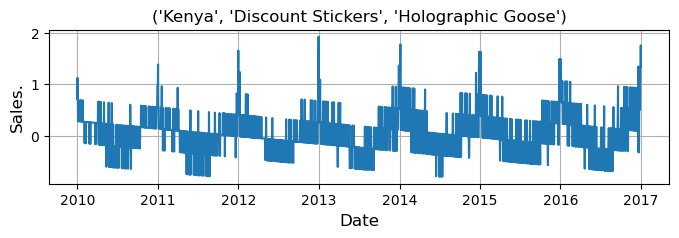

['slope = ', 0.00040217264141971146, 'intercept = ', 1.802367733494524]


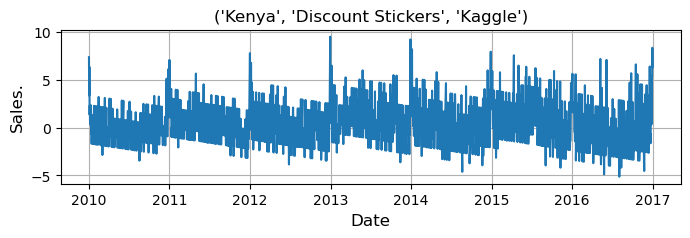

['slope = ', 0.0035298846169268395, 'intercept = ', 12.648029691268656]


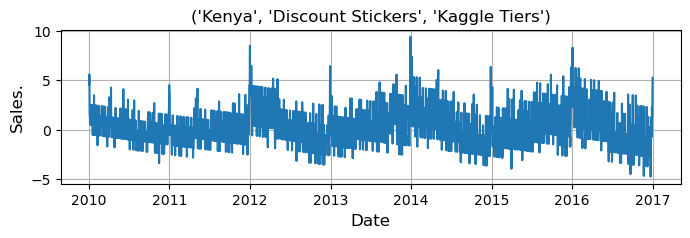

['slope = ', 0.00285897251265415, 'intercept = ', 10.454902102674742]


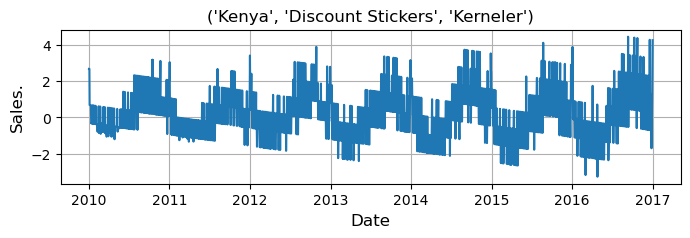

['slope = ', 0.0017262450286812852, 'intercept = ', 5.304244504789612]


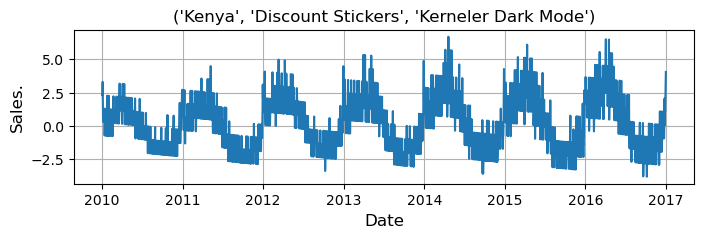

['slope = ', 0.001667963998451382, 'intercept = ', 6.691299989620473]


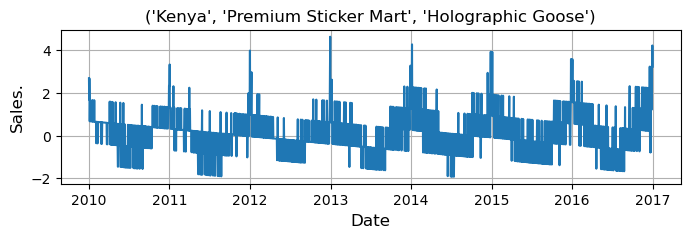

['slope = ', 0.0009652143394073089, 'intercept = ', 4.325682560386856]


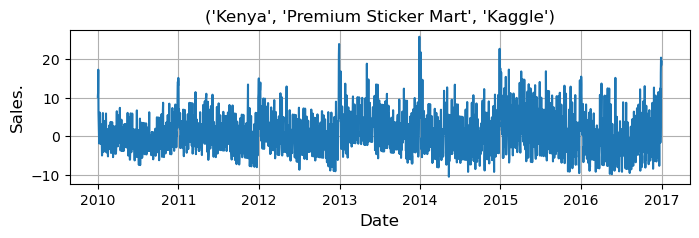

['slope = ', 0.008576422071914851, 'intercept = ', 30.768155525768677]


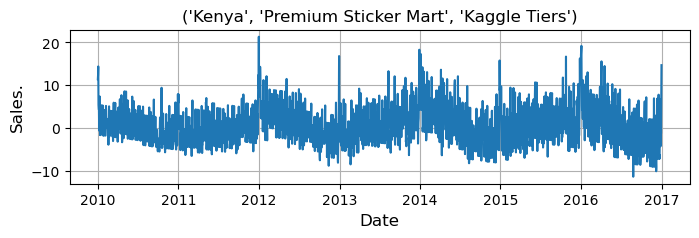

['slope = ', 0.006933583030268922, 'intercept = ', 25.596605092634583]


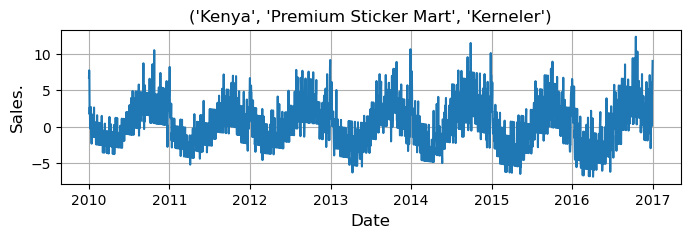

['slope = ', 0.0041931164677140665, 'intercept = ', 13.254964985450858]


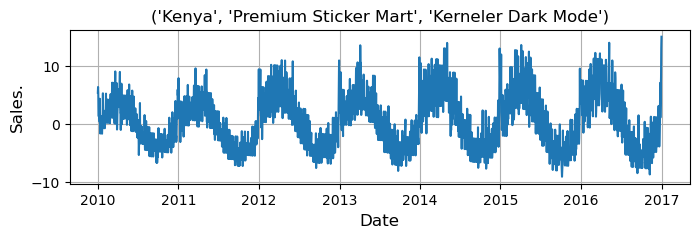

['slope = ', 0.004040984210440563, 'intercept = ', 16.661031283986706]


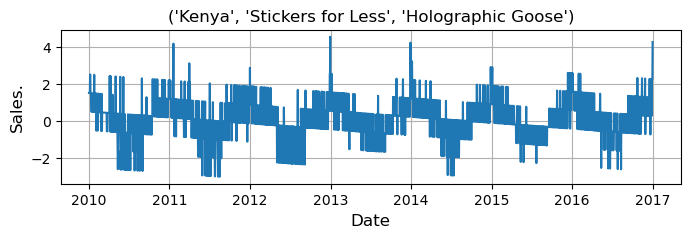

['slope = ', 0.0008811082426438982, 'intercept = ', 3.472705615594512]


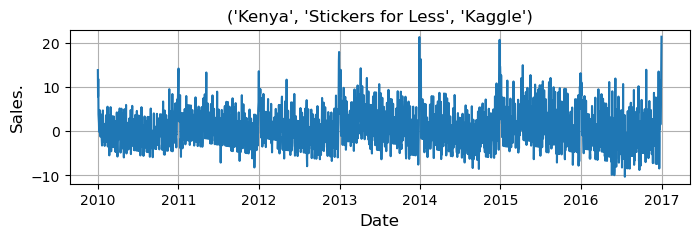

['slope = ', 0.007210054460769738, 'intercept = ', 26.068732949121024]


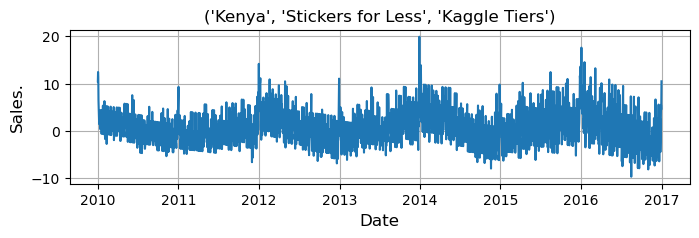

['slope = ', 0.005861194538291268, 'intercept = ', 21.547162692064546]


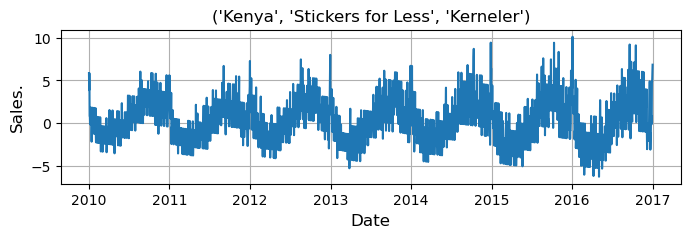

['slope = ', 0.003526070022753921, 'intercept = ', 11.138631837183711]


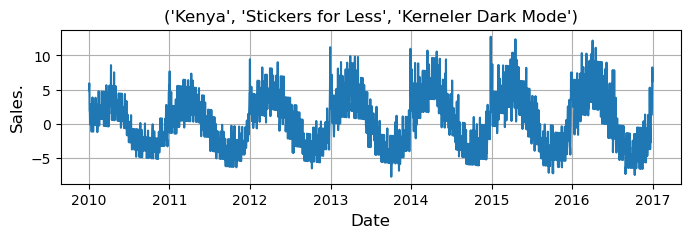

['slope = ', 0.0033942532007519626, 'intercept = ', 14.073673505446806]


In [808]:
linear_reg = dict()

for group_name, df in data_Kenya.groupby(group_categories,observed=True):

    slope, intercept = np.polyfit(df['daysfromstart'].to_numpy(), df['num_sold'].to_numpy(), 1)
    linear_reg[group_name] = [slope,intercept]

    trend_mean = slope*df['daysfromstart'].to_numpy() + intercept

    data_Kenya.loc[df.index,'trend_res'] = df['num_sold'].to_numpy() - trend_mean

    plt.figure(figsize=(8, 2))
    #plt.plot(df['date'].to_numpy(), df['num_sold'].to_numpy())
    plt.plot(df['date'].to_numpy(), df['num_sold'].to_numpy() - trend_mean)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Sales.", fontsize=12)
    plt.grid(True)
    plt.title(f"{group_name}")
    #plt.legend(title="Feature Combination")
    plt.show()

    print(['slope = ',slope,'intercept = ',intercept])

In [816]:
model_Kenya = xgb.XGBRegressor(n_estimators=1000,
                               enable_categorical='True',
                               max_depth=8,
                               #max_leaves=10,
                               learning_rate=0.2,random_state=42)

model_Kenya.fit(data_Kenya.drop(columns=['id','date','num_sold','norm_res','trend_res','year']),data_Kenya['trend_res'])

prediction_Kenya = model_Kenya.predict(inference_Kenya.drop(columns=['id','date','year']))

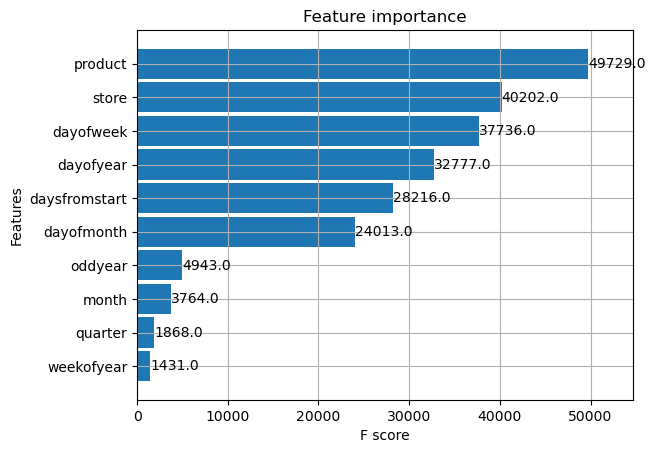

In [817]:
_ = xgb.plot_importance(model_Kenya, height=0.9)

In [818]:
df_prediction_Kenya = inference_Kenya.copy()
df_prediction_Kenya['trend_res'] = prediction_Kenya

for group_name, df in df_prediction_Kenya.groupby(group_categories,observed=True):

    coef = linear_reg[group_name]
    df_prediction_Kenya.loc[df.index,'num_sold'] = df_prediction_Kenya.loc[df.index,'trend_res'] + coef[0]*df['daysfromstart'].to_numpy() + coef[1]

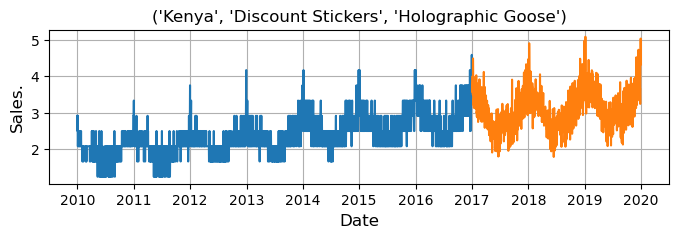

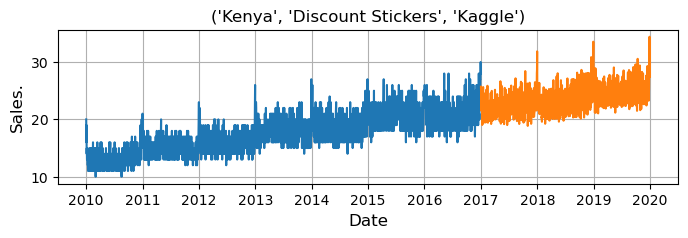

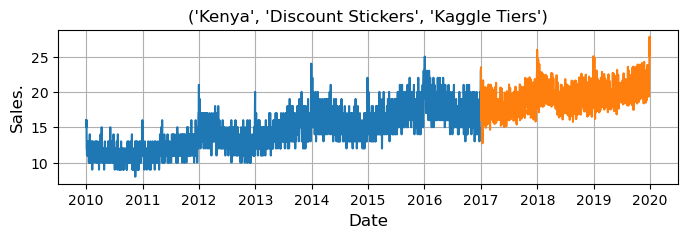

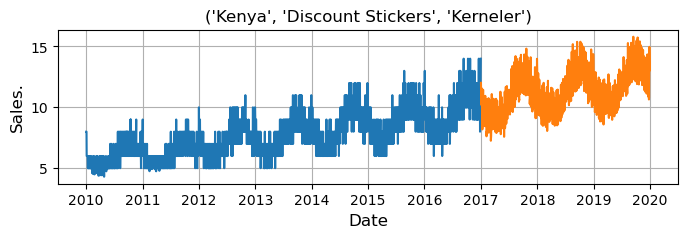

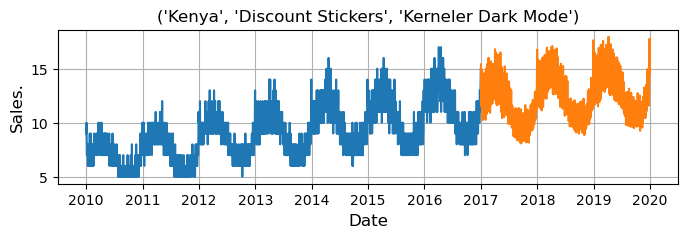

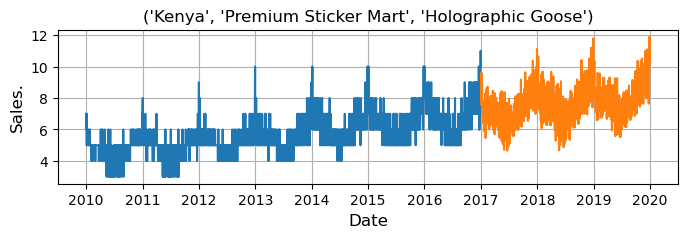

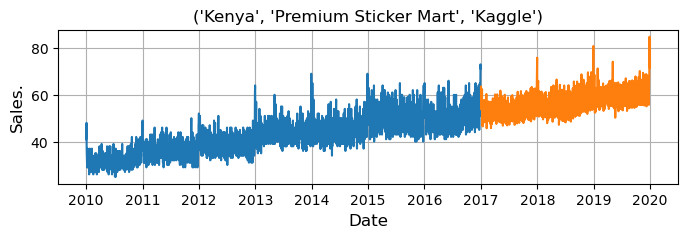

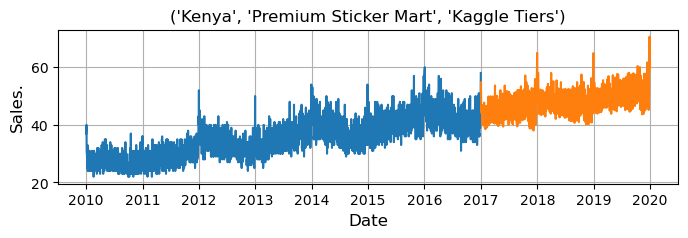

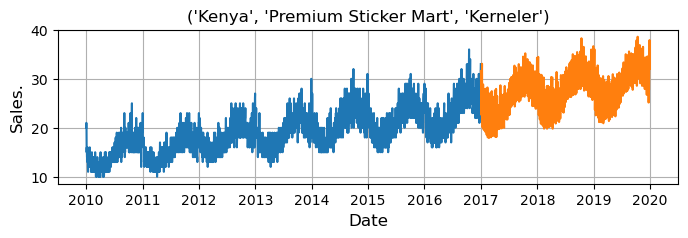

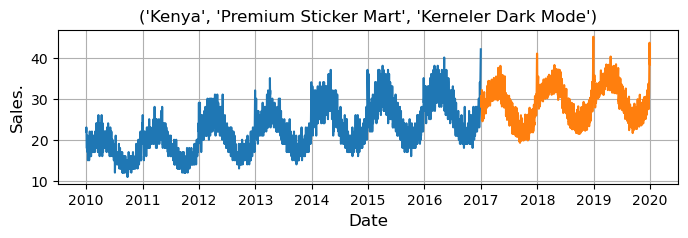

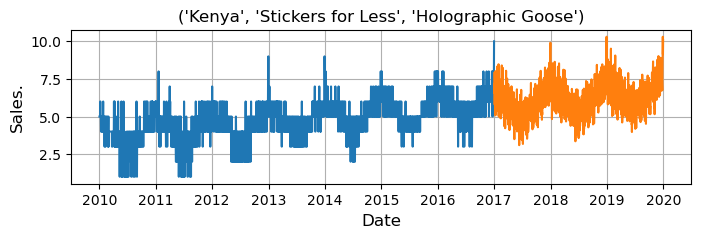

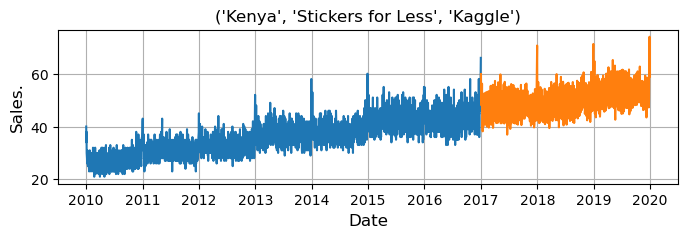

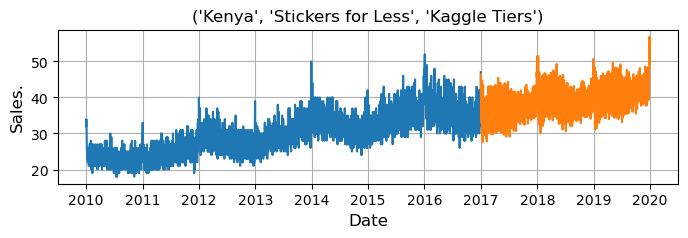

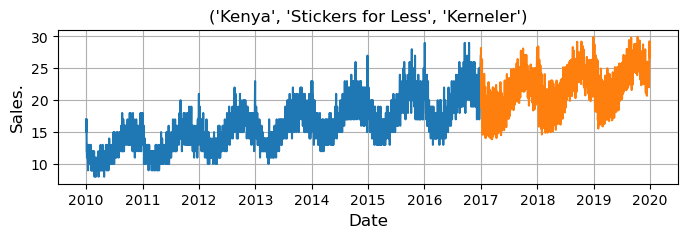

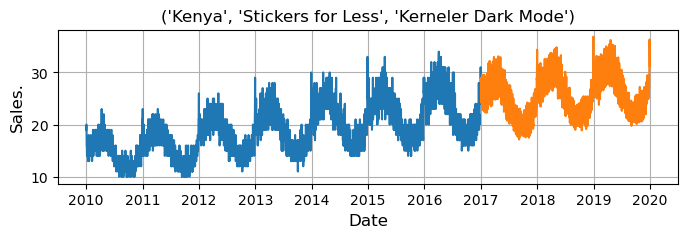

In [819]:
for (group_name, df_train), (_, df_predict) in zip(data_Kenya.groupby(group_categories,observed=True),df_prediction_Kenya.groupby(group_categories,observed=True)):

    plt.figure(figsize=(8, 2))
    plt.plot(df_train['date'].to_numpy(), df_train['num_sold'].to_numpy())
    plt.plot(df_predict['date'].to_numpy(), df_predict['num_sold'].to_numpy())
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Sales.", fontsize=12)
    plt.grid(True)
    plt.title(f"{group_name}")
    #plt.legend(title="Feature Combination")
    plt.show()

In [820]:
df_prediction_Kenya_grouped = df_prediction_Kenya.groupby(group_categories,observed=True)

df_Kenya_1 = df_prediction_Kenya_grouped.get_group(('Kenya', 'Discount Stickers', 'Holographic Goose')).copy()

df_Kenya_1['num_sold'] = df_Kenya_1['num_sold']
#df_Kenya_1.loc[df_Kenya_1['num_sold'] < 2.0,'num_sold'] = 2.0

df_Kenya_2 = df_prediction_Kenya_grouped.get_group(('Kenya', 'Stickers for Less', 'Holographic Goose')).copy()

df_Kenya_2['num_sold'] = df_Kenya_2['num_sold']

df_Kenya_3 = df_prediction_Kenya_grouped.get_group(('Kenya', 'Premium Sticker Mart', 'Holographic Goose')).copy()

df_Kenya_3['num_sold'] = df_Kenya_3['num_sold']


df_prediction_Kenya.loc[df_Kenya_1.index,'num_sold'] = df_Kenya_1
df_prediction_Kenya.loc[df_Kenya_2.index,'num_sold'] = df_Kenya_2
df_prediction_Kenya.loc[df_Kenya_3.index,'num_sold'] = df_Kenya_3


In [ ]:
# model = xgb.XGBRegressor(n_estimators=1000,
#                         #early_stopping_rounds=10,
#                         enable_categorical='True',
#                         max_depth=5,
#                         max_leaves=10,
#                         learning_rate=0.1,random_state=42)

# test_target = []
# inference = []

# for (group_name_train, df_train), (group_name_test, df_test) in zip(train_data_filled.groupby(group_categories,observed=True),test_data_filled.groupby(group_categories,observed=True)):

#     model.fit(df_train[['dayofyear','dayofweek','year','month','weekofyear']],df_train['num_sold'],
#          #eval_set=[(train_data,train_target),(test_data,test_target)],
#           verbose=True)

#     prediction = model.predict(df_test[['dayofyear','dayofweek','year','month','weekofyear']])

#     test_target.extend(df_test['num_sold'].values)
#     inference.extend(prediction)
    
#     # plt.figure(figsize=(5, 2))
#     # plt.plot(df_train['date'], df_train['num_sold'])
#     # plt.plot(df_test['date'], df_test['num_sold'],color='blue')
#     # plt.plot(df_test['date'], prediction,marker='o',linestyle='none')
#     # plt.xlabel("Date", fontsize=12)
#     # plt.ylabel("Sales", fontsize=12)
#     # plt.grid(True)
#     # plt.legend(title=f"{group_name_train}")
#     # plt.show()
    

In [ ]:
# mean_absolute_percentage_error(test_target,inference)

# Main prediction

In [798]:
inference_pack.head(5)

id        date country              store             product
0  230130  2017-01-01  Canada  Discount Stickers   Holographic Goose
1  230131  2017-01-01  Canada  Discount Stickers              Kaggle
2  230132  2017-01-01  Canada  Discount Stickers        Kaggle Tiers
3  230133  2017-01-01  Canada  Discount Stickers            Kerneler
4  230134  2017-01-01  Canada  Discount Stickers  Kerneler Dark Mode

In [346]:
inference_pack_aux = inference_pack.copy()
inference_pack_aux['num_sold'] = np.nan
inference_data = datetime_processing(inference_pack_aux)

In [347]:
inference_data.head(2)

id                 date country              store            product  \
0  230130  2017-01-01 00:00:00  Canada  Discount Stickers  Holographic Goose   
1  230131  2017-01-01 00:00:00  Canada  Discount Stickers             Kaggle   

   num_sold  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0       NaN          6        1      1   8.0          1           1   
1       NaN          6        1      1   8.0          1           1   

   weekofyear  oddyear  daysfromstart  
0           1        1         2556.0  
1           1        1         2556.0

In [799]:
train_data_final, target_data_final, _, _ = train_test_split(data_pack_filled,pd.to_datetime('2020-01-01'))

In [491]:
train_data_final.head(2)

id                 date country              store            product  \
0   0  2010-01-01 00:00:00  Canada  Discount Stickers  Holographic Goose   
1   1  2010-01-01 00:00:00  Canada  Discount Stickers             Kaggle   

   num_sold  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0    156.25          4        1      1   1.0          1           1   
1    973.00          4        1      1   1.0          1           1   

   weekofyear  oddyear  daysfromstart  
0           1        0            1.0  
1           1        0            1.0

In [800]:
columns_to_drop_final = ['id','date','num_sold','year','daysfromstart']

#train_data_final_cut = train_data_final[train_data_final['date'] > pd.to_datetime('2014-12-31')].copy()
#target_data_final_cut = target_data_final[train_data_final_cut.index].copy()

model_final = xgb.XGBRegressor(n_estimators=1000,
                        #early_stopping_rounds=10,
                        enable_categorical='True',
                        max_depth=10,
                        #max_leaves=6,
                        learning_rate=0.2,random_state=42)
start_time = time.time()
model_final.fit(train_data_final.drop(columns=columns_to_drop_final),target_data_final,
         #eval_set=[(train_data,train_target),(test_data,test_target)],
          verbose=True)
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

Elapsed time: 12.955640316009521 s


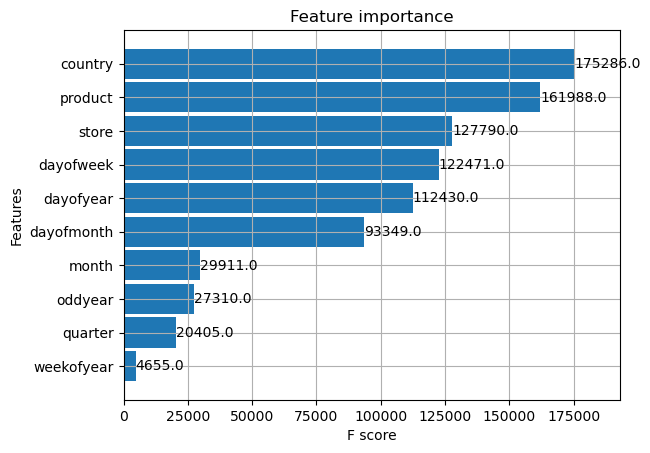

In [410]:
_ = xgb.plot_importance(model_final, height=0.9)

In [801]:
predictions_final = model_final.predict(inference_data.drop(columns=columns_to_drop_final))

df_predictions_final = inference_data[['id','date','country','store','product','year']].copy()
df_predictions_final['norm_res'] = predictions_final

recover_num_sold(df_predictions_final,reg_coefs)

Kenya, Discount Stickers, Holographic Goose 

Kenya, Stickers for Less, Holographic Goose

Kenya, Premium Sticker Mart, Holographic Goose

In [821]:
df_predictions_final.loc[df_Kenya_1.index,'num_sold'] = df_Kenya_1['num_sold']
df_predictions_final.loc[df_Kenya_2.index,'num_sold'] = df_Kenya_2['num_sold']
df_predictions_final.loc[df_Kenya_3.index,'num_sold'] = df_Kenya_3['num_sold']

/tmp/ipykernel_509000/819174752.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.63913219 3.5714115  3.70116618 ... 5.02852483 4.4797608  4.32439279]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_predictions_final.loc[df_Kenya_1.index,'num_sold'] = df_Kenya_1['num_sold']


In [413]:
df_predictions_final.head(5)

id                 date country              store             product  \
0  230130  2017-01-01 00:00:00  Canada  Discount Stickers   Holographic Goose   
1  230131  2017-01-01 00:00:00  Canada  Discount Stickers              Kaggle   
2  230132  2017-01-01 00:00:00  Canada  Discount Stickers        Kaggle Tiers   
3  230133  2017-01-01 00:00:00  Canada  Discount Stickers            Kerneler   
4  230134  2017-01-01 00:00:00  Canada  Discount Stickers  Kerneler Dark Mode   

   year  norm_res    num_sold  
0   8.0  3.900567  123.683182  
1   8.0  2.585194  793.869873  
2   8.0  3.143744  697.471252  
3   8.0  2.102676  375.821106  
4   8.0  1.059214  402.235352

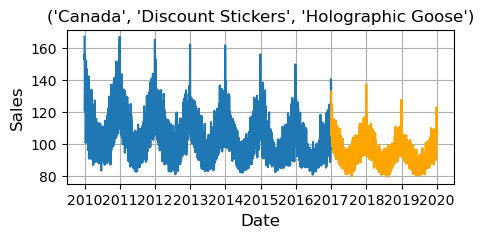

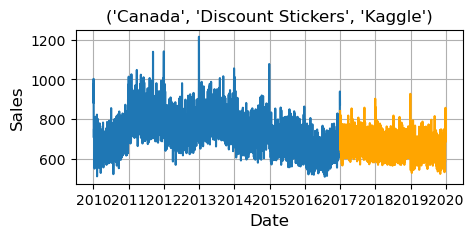

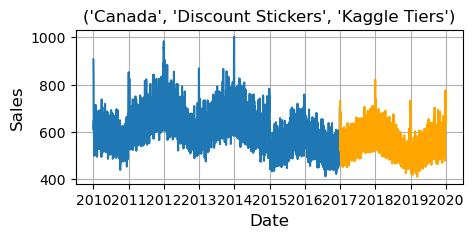

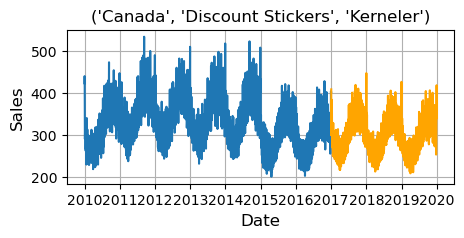

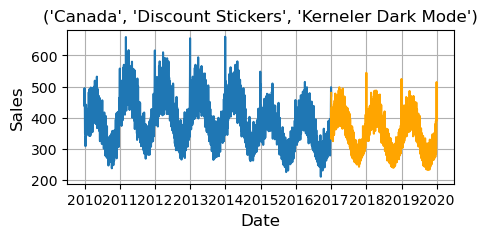

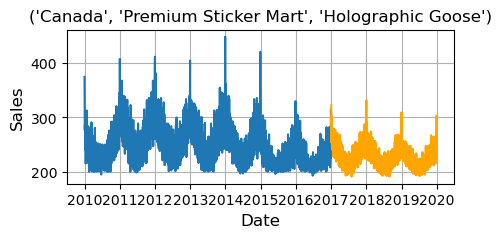

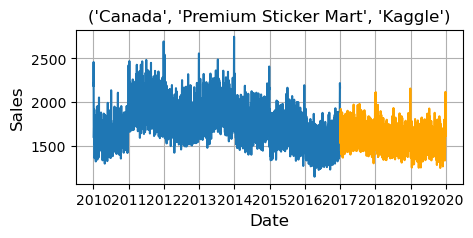

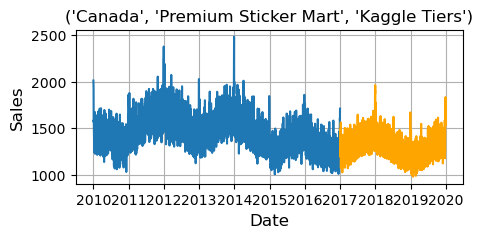

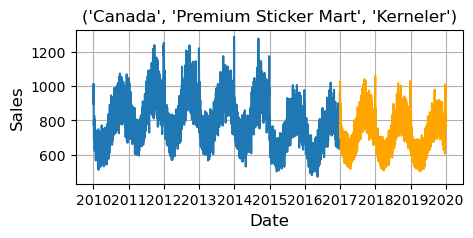

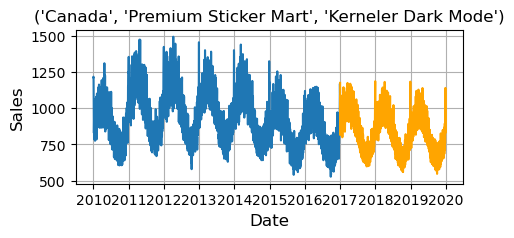

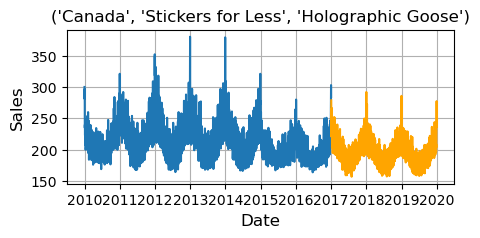

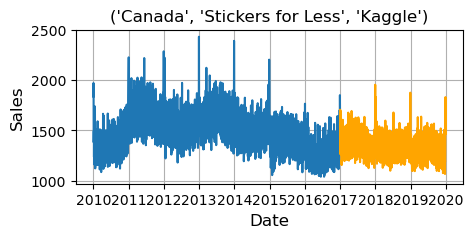

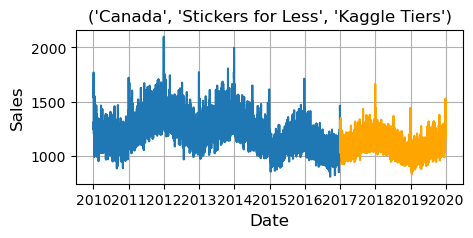

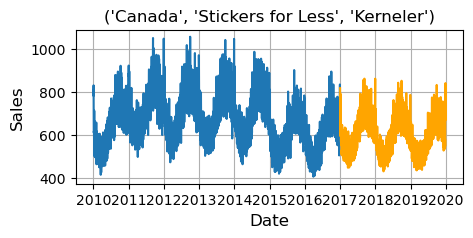

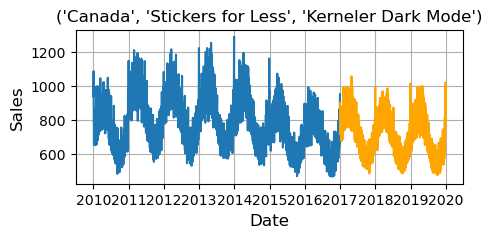

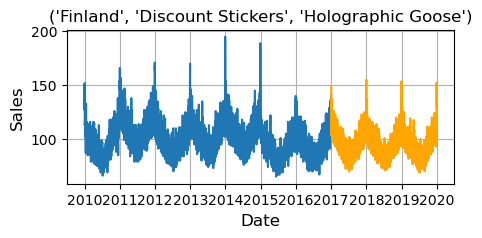

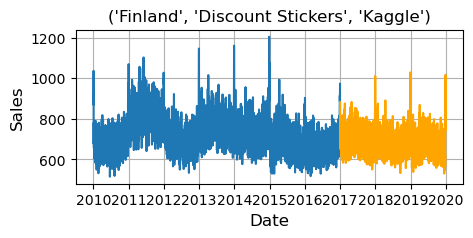

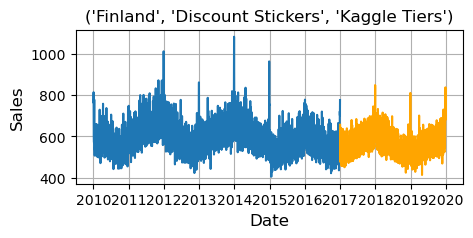

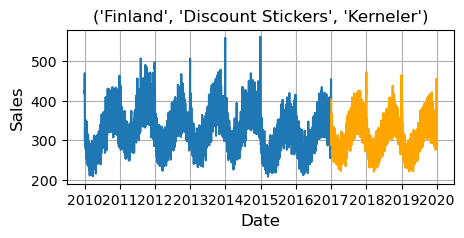

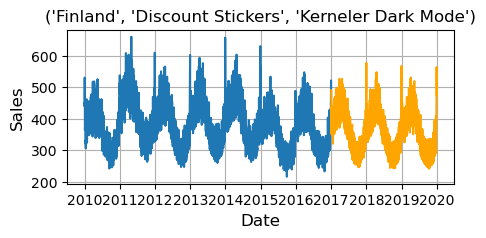

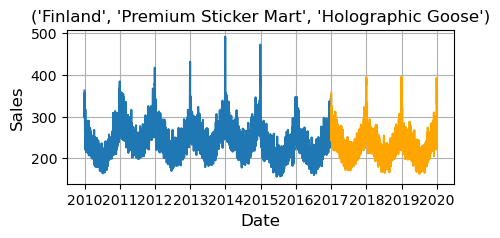

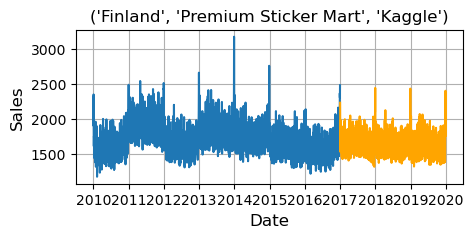

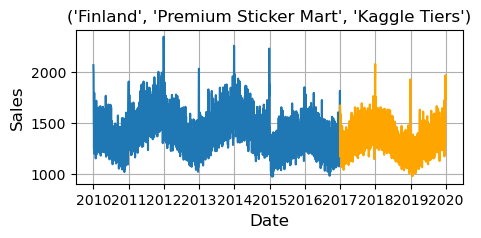

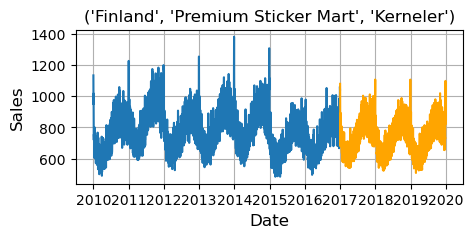

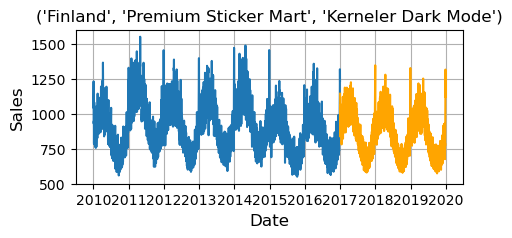

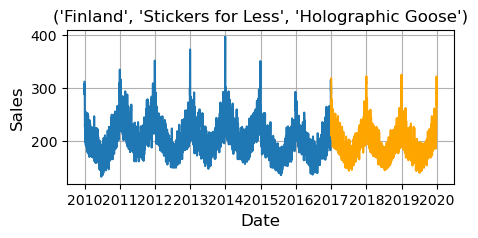

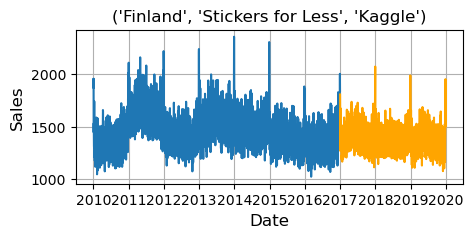

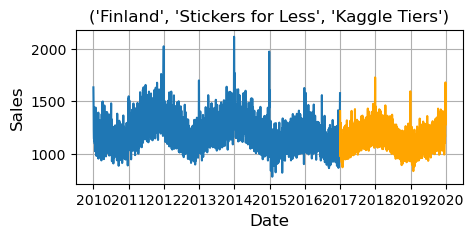

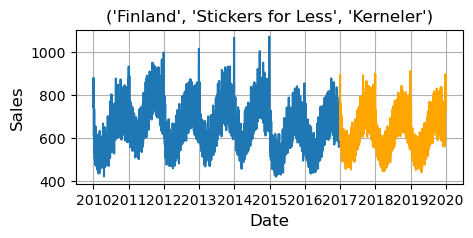

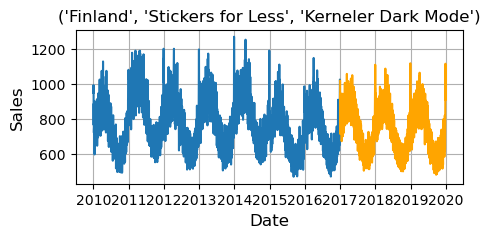

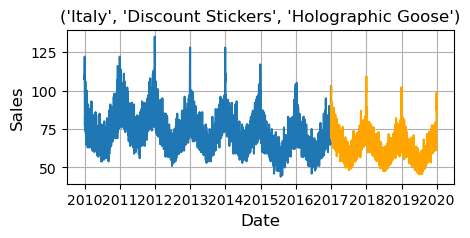

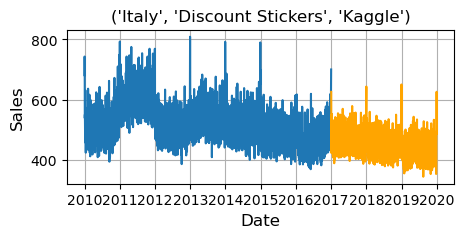

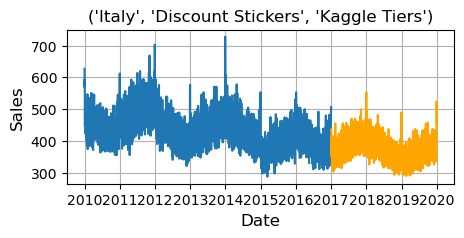

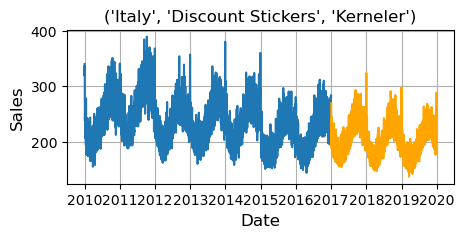

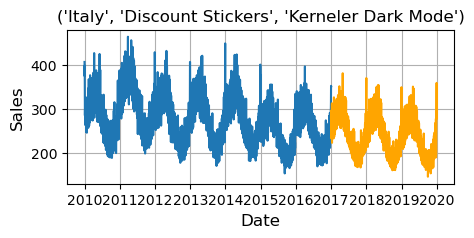

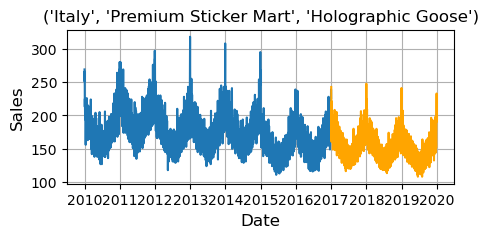

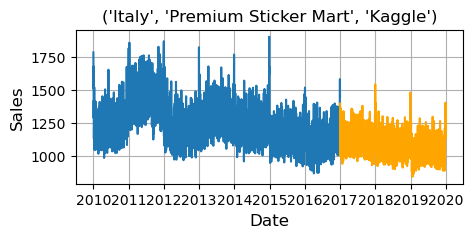

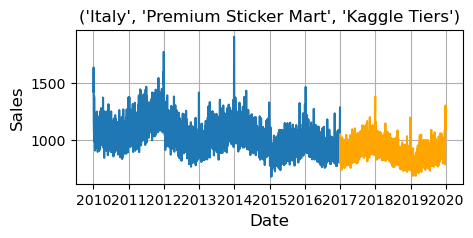

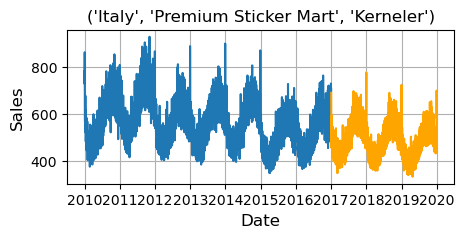

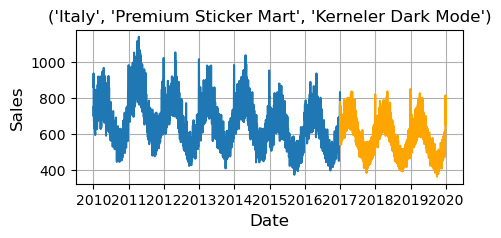

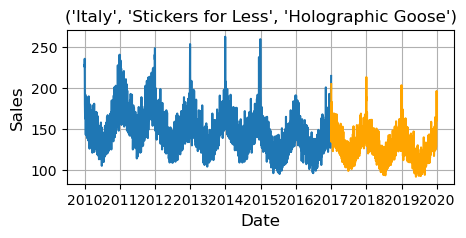

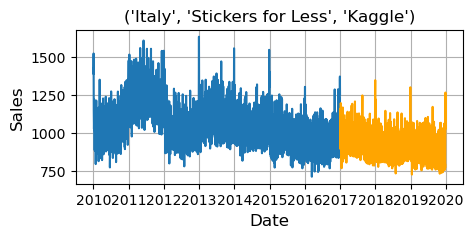

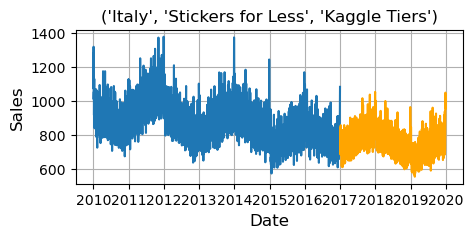

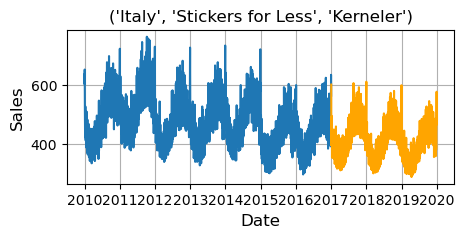

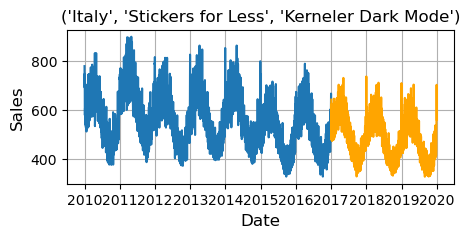

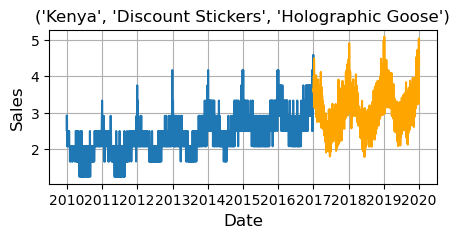

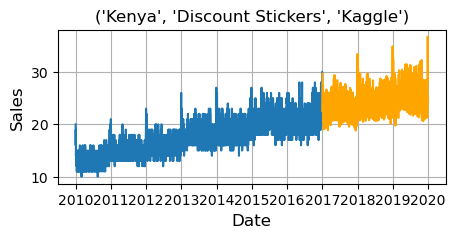

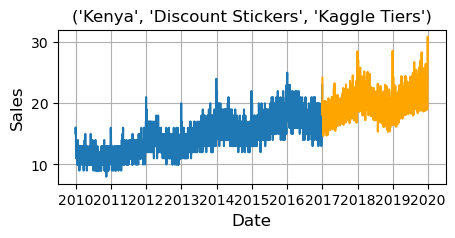

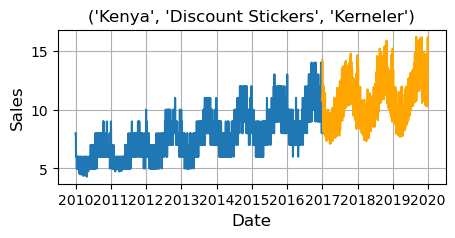

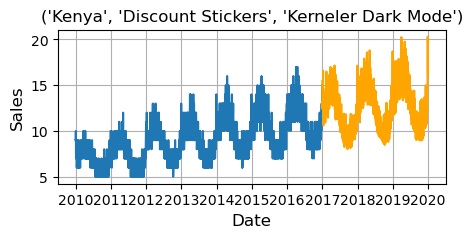

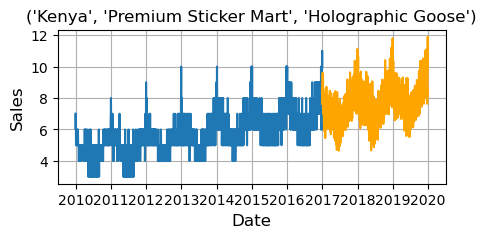

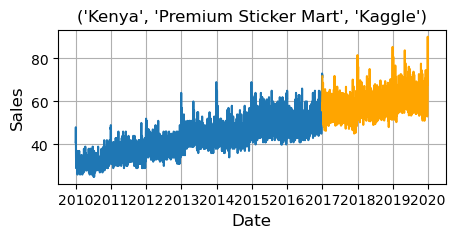

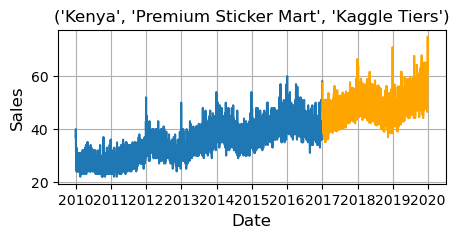

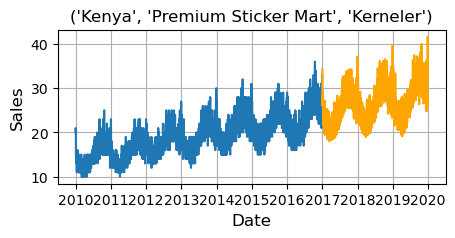

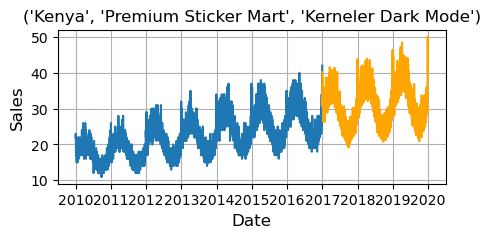

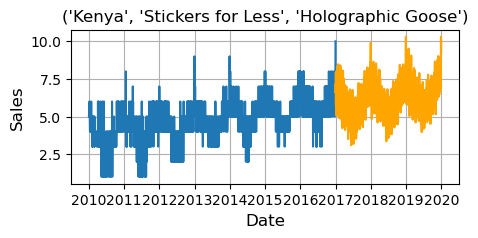

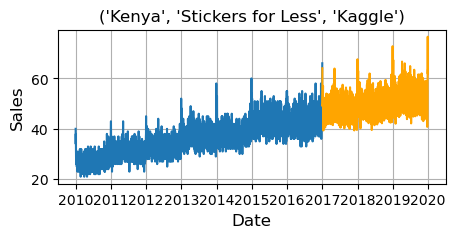

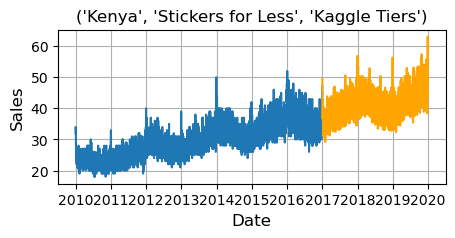

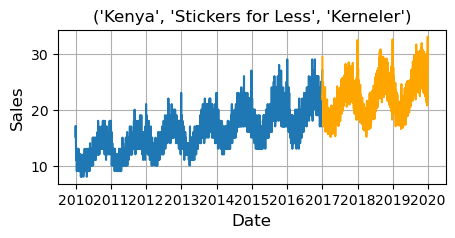

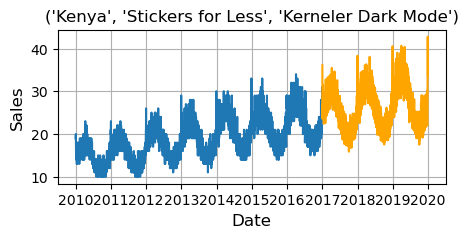

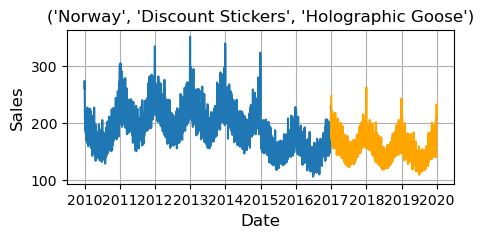

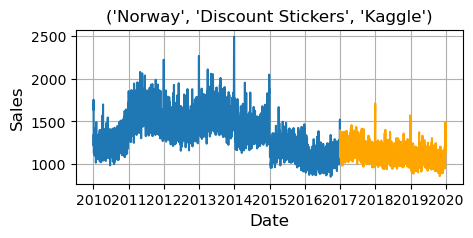

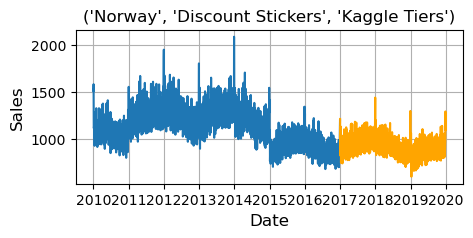

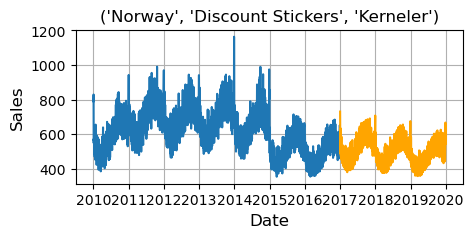

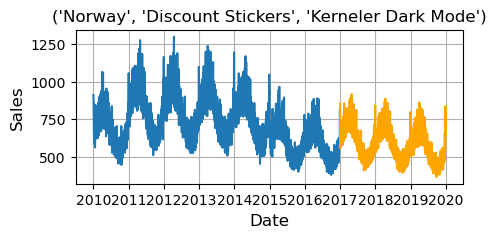

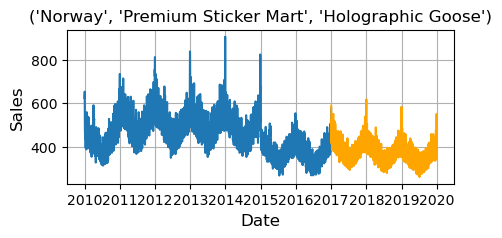

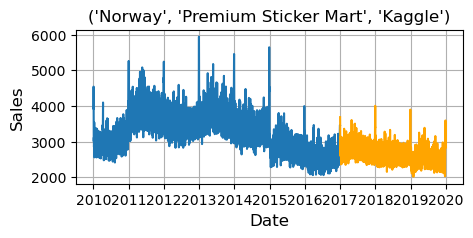

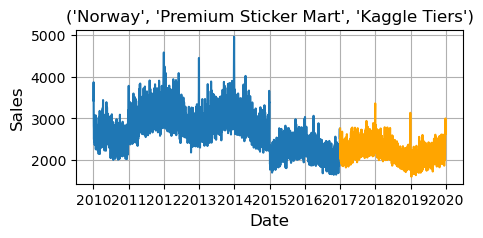

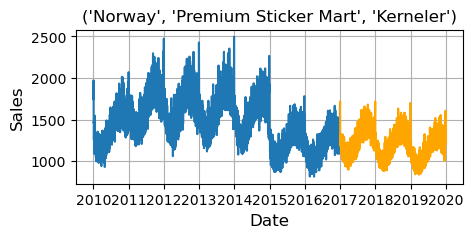

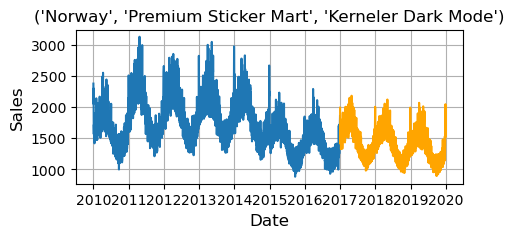

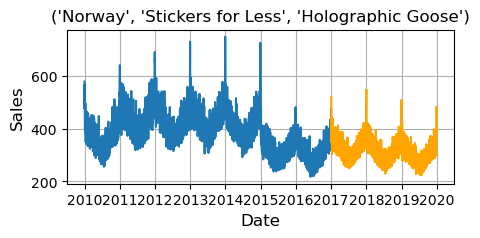

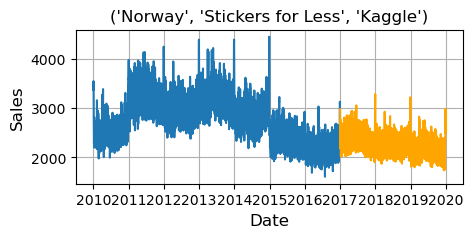

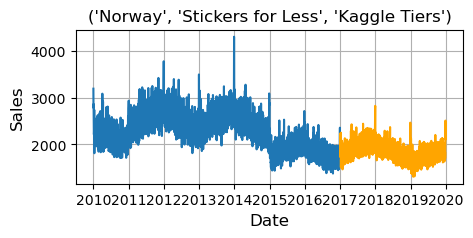

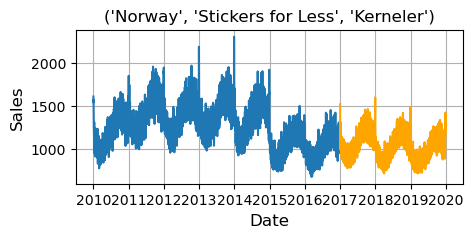

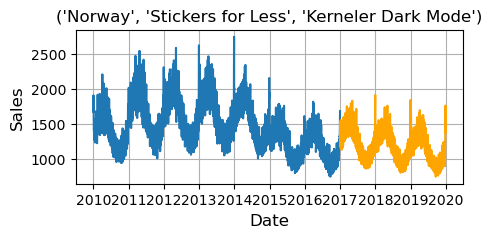

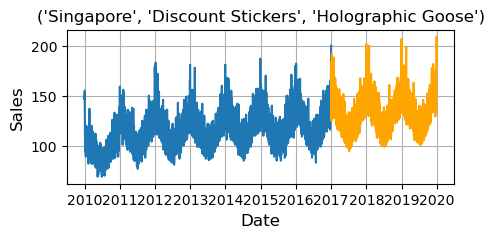

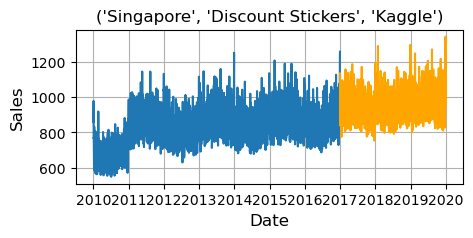

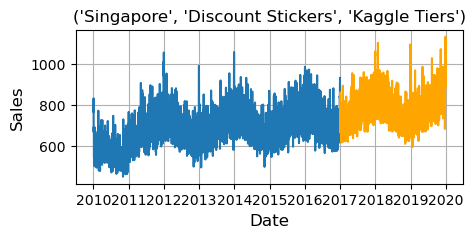

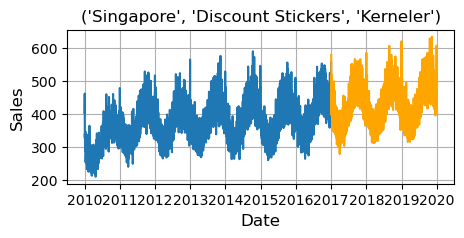

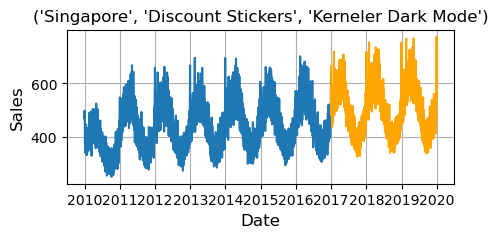

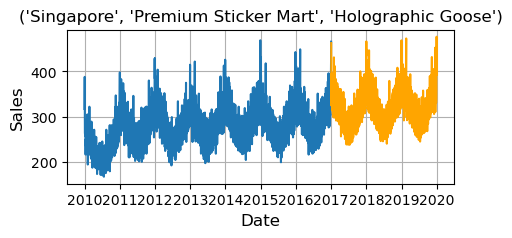

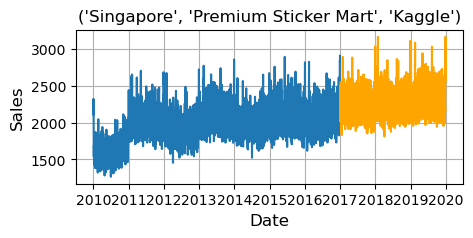

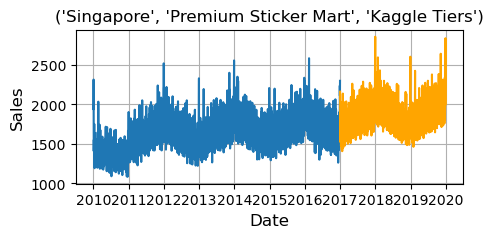

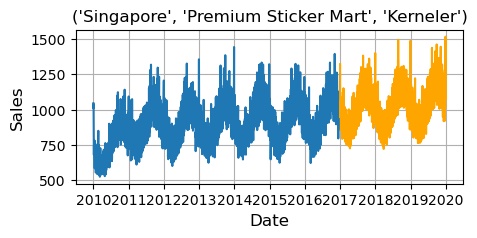

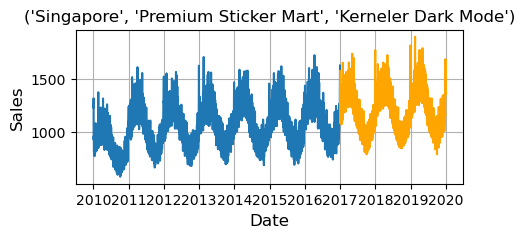

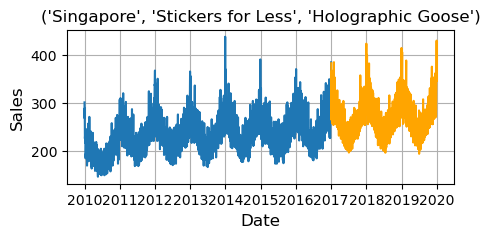

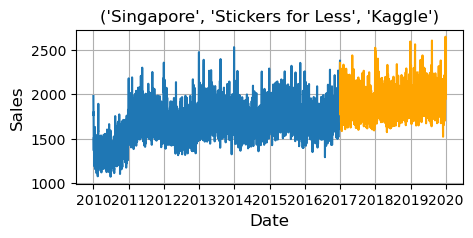

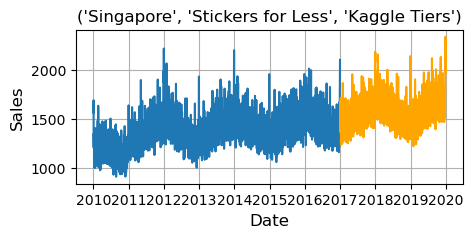

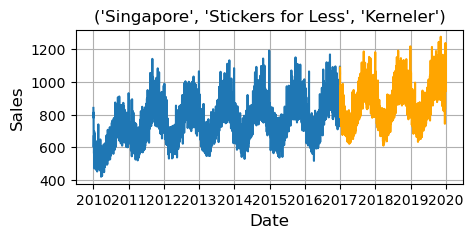

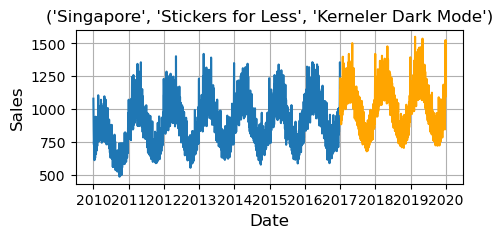

In [822]:
df_train_full_grouped = data_pack_filled.groupby(group_categories,observed=True)

for group_name, df_prediction in df_predictions_final.groupby(group_categories,observed=True):

    df_train = df_train_full_grouped.get_group(group_name)
    
    plt.figure(figsize=(5, 2))
    plt.plot(df_train['date'].to_numpy(), df_train['num_sold'].to_numpy())
    plt.plot(df_prediction['date'].to_numpy(), df_prediction['num_sold'].to_numpy(),color='orange')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Sales", fontsize=12)
    plt.grid(True)
    plt.title(f"{group_name}")
    #plt.legend(title=f"{group_name}")
    plt.show()

In [823]:
prediction_df = pd.DataFrame(df_predictions_final['id'].copy())
prediction_df['num_sold'] = df_predictions_final['num_sold']

prediction_df.to_csv('submission.csv', index=False)

In [824]:
prediction_df.head(5)

id    num_sold
0  230130  132.831345
1  230131  840.484985
2  230132  729.460571
3  230133  408.351257
4  230134  479.715149